In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc

from tqdm import tqdm

import pywt
import librosa

In [2]:
train = pd.read_csv('updated_train.csv')
print('Train shape', train.shape)
display(train.head() )

Train shape (100784, 15)


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   

   grda_vote  other_vote  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0

In [3]:
NAMES = ['LL','LP','RP','RR','LZ','RZ']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2'],
         ['Fp1','Fz','Cz','Pz','O1'],
         ['Fp2','Fz','Cz','Pz','O2'],
        ]

directory_path = 'EEG_Spectrograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

In [4]:
USE_WAVELET = None

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

In [5]:
def spectrogram_from_eeg(parquet_path, display=False):
    
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    img = np.zeros((192,768,6),dtype='float32')
    
    if display: plt.figure(figsize=(10,12))
    signals = []
    for k in range(6):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//768, 
                  n_fft=1024, n_mels=192, fmin=0, fmax=20, win_length=128)

            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(3,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,7))
        offset = 0
        for k in range(6):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

  0%|                                                                                        | 0/16064 [00:00<?, ?it/s]

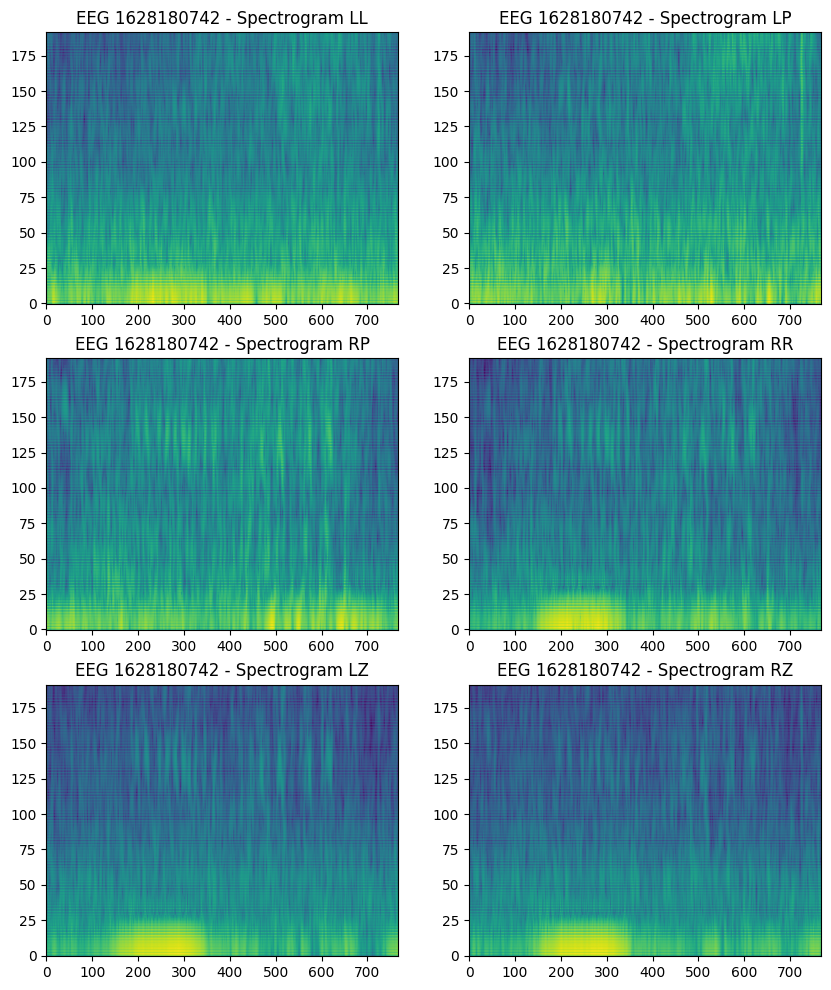

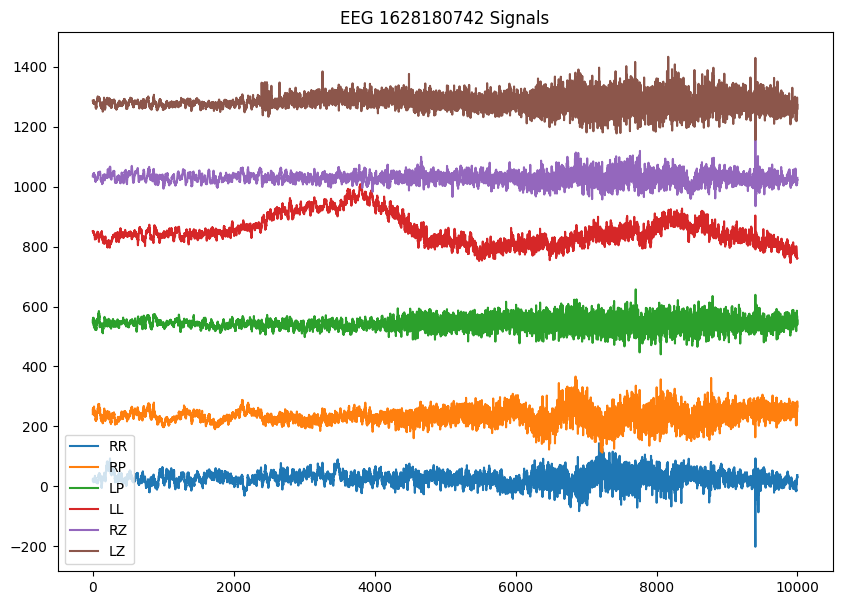

  0%|                                                                              | 1/16064 [00:01<6:13:34,  1.40s/it]


#########################



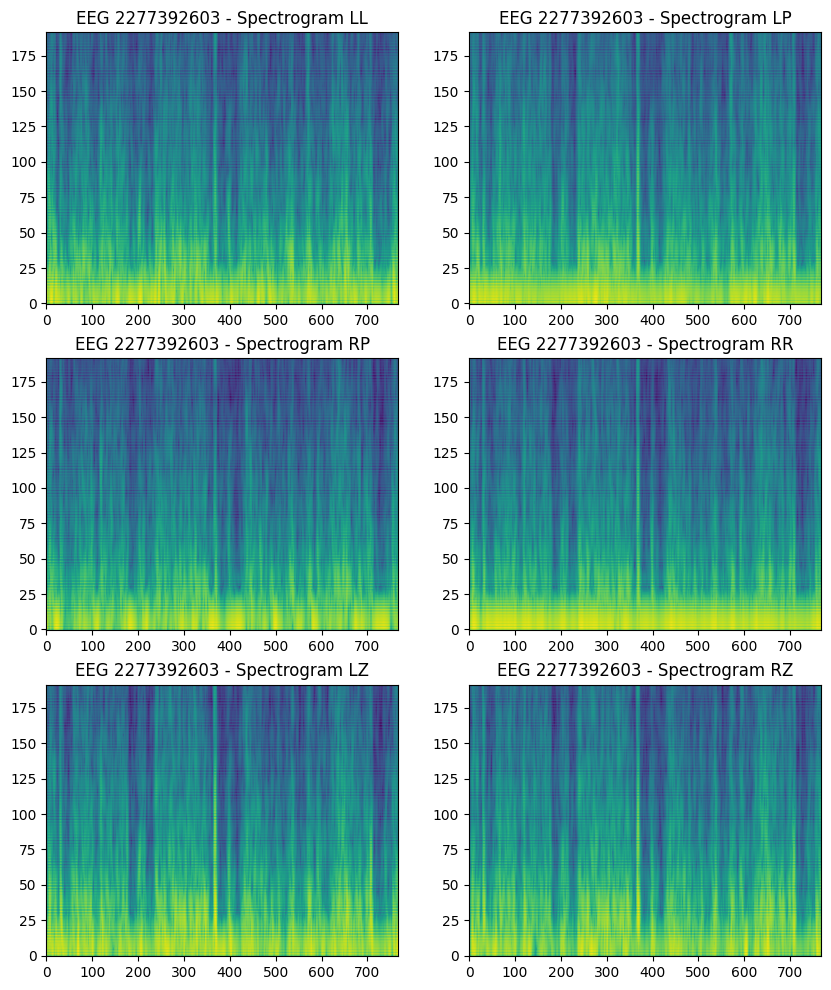

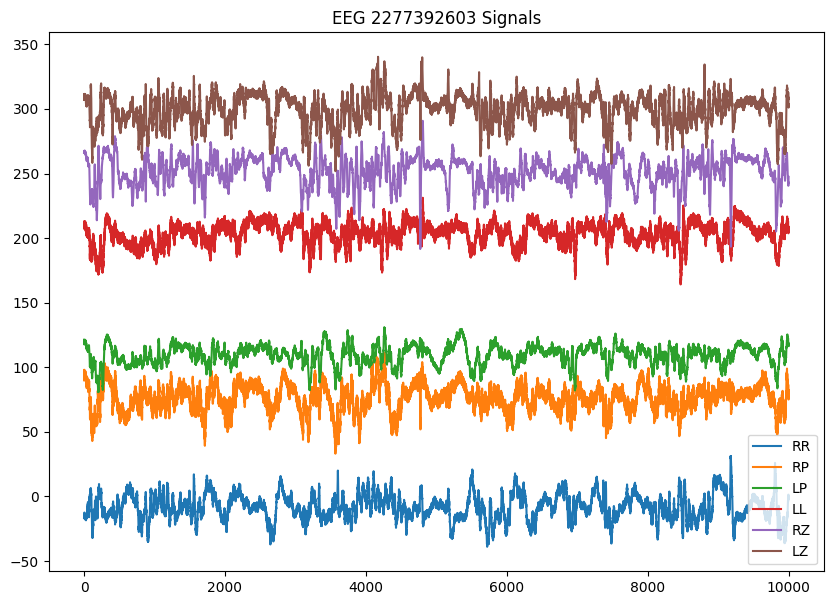


#########################



  0%|                                                                             | 2/16064 [00:04<11:11:55,  2.51s/it]

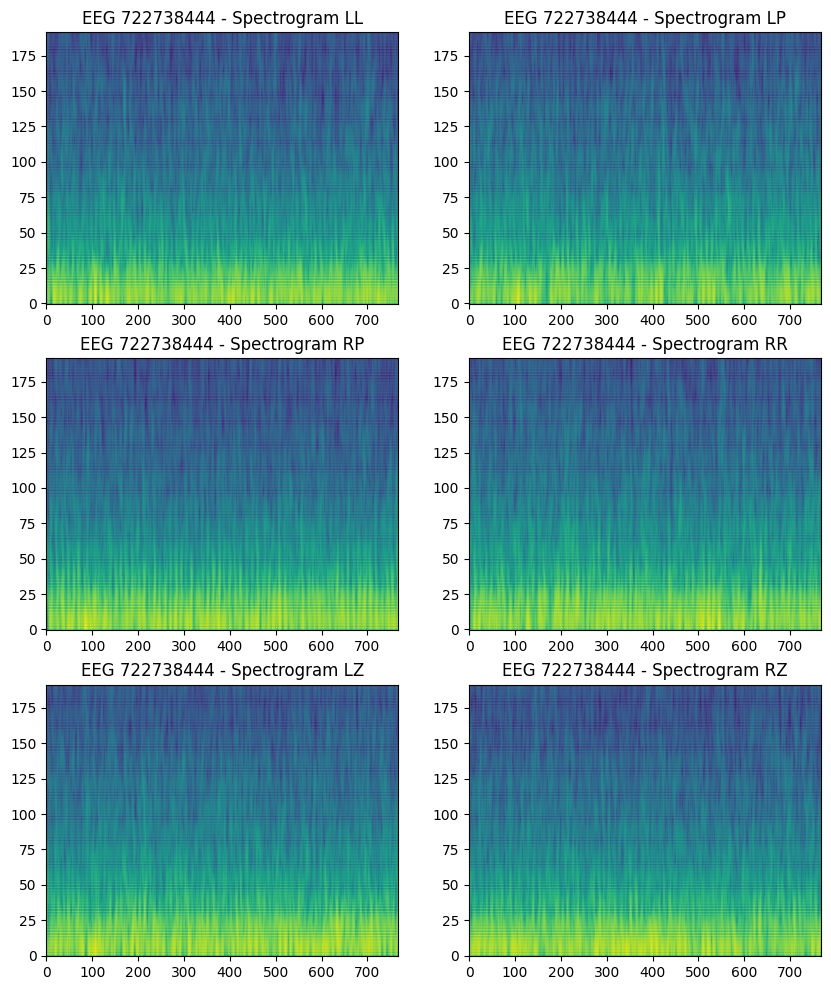

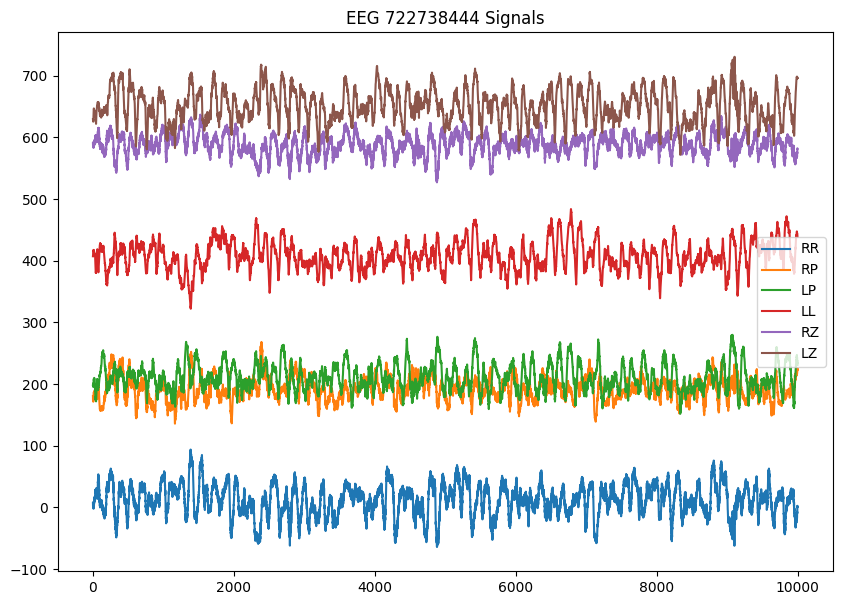

  0%|                                                                              | 3/16064 [00:06<9:07:33,  2.05s/it]


#########################



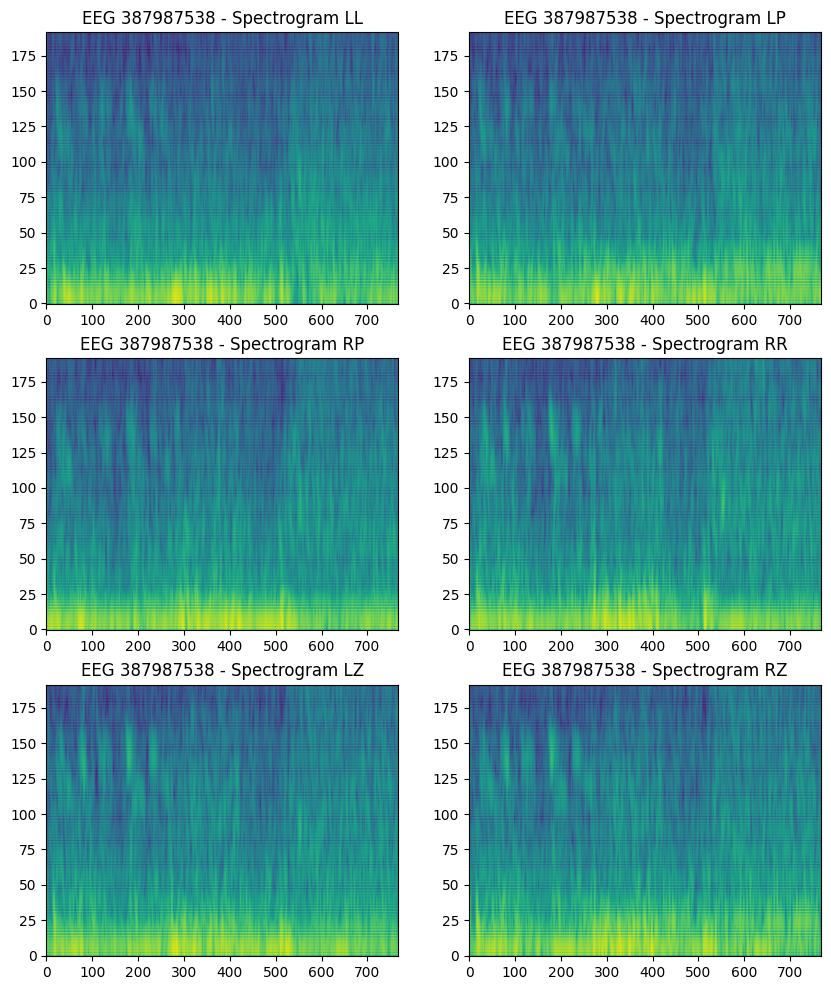

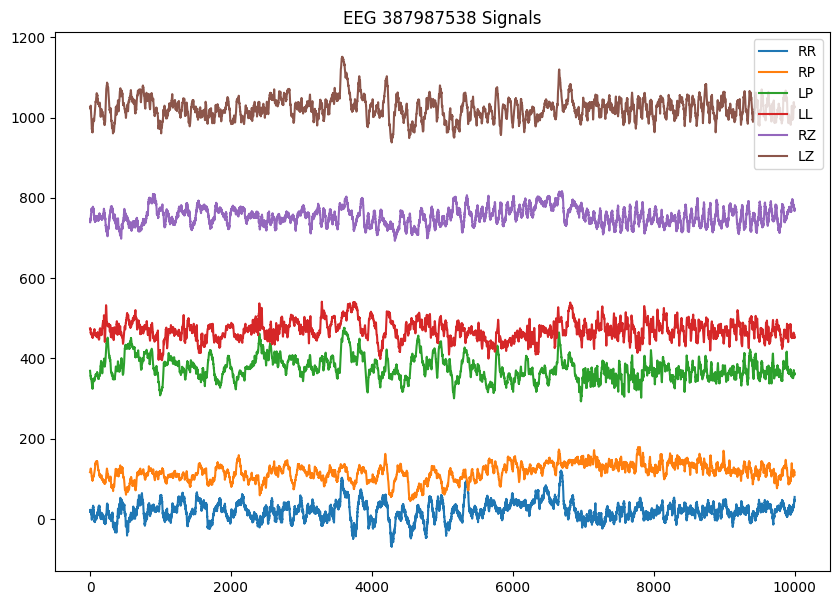

  0%|                                                                              | 4/16064 [00:07<8:06:08,  1.82s/it]


#########################



  0%|                                                                              | 5/16064 [00:08<5:48:18,  1.30s/it]

Creating and writing 16064 spectrograms to disk... 

  1%|▍                                                                           | 100/16064 [00:43<1:52:58,  2.36it/s]

100 , 

  1%|▉                                                                           | 200/16064 [01:22<1:42:09,  2.59it/s]

200 , 

  2%|█▍                                                                          | 300/16064 [02:01<1:48:56,  2.41it/s]

300 , 

  2%|█▉                                                                          | 400/16064 [02:38<1:35:28,  2.73it/s]

400 , 

  3%|██▎                                                                         | 500/16064 [03:17<1:58:41,  2.19it/s]

500 , 

  4%|██▊                                                                         | 600/16064 [03:54<1:33:20,  2.76it/s]

600 , 

  4%|███▎                                                                        | 700/16064 [04:32<1:31:49,  2.79it/s]

700 , 

  5%|███▊                                                                        | 800/16064 [05:09<1:31:46,  2.77it/s]

800 , 

  6%|████▎                                                                       | 900/16064 [05:48<1:23:25,  3.03it/s]

900 , 

  6%|████▋                                                                      | 1000/16064 [06:25<1:48:21,  2.32it/s]

1000 , 

  7%|█████▏                                                                     | 1100/16064 [07:02<1:27:19,  2.86it/s]

1100 , 

  7%|█████▌                                                                     | 1200/16064 [07:39<1:59:16,  2.08it/s]

1200 , 

  8%|██████                                                                     | 1300/16064 [08:16<1:42:26,  2.40it/s]

1300 , 

  9%|██████▌                                                                    | 1400/16064 [08:53<1:33:54,  2.60it/s]

1400 , 

  9%|███████                                                                    | 1500/16064 [09:31<1:23:59,  2.89it/s]

1500 , 

 10%|███████▍                                                                   | 1600/16064 [10:09<1:26:37,  2.78it/s]

1600 , 

 11%|███████▉                                                                   | 1700/16064 [10:45<1:23:06,  2.88it/s]

1700 , 

 11%|████████▍                                                                  | 1800/16064 [11:22<1:29:21,  2.66it/s]

1800 , 

 12%|████████▊                                                                  | 1900/16064 [11:56<1:35:33,  2.47it/s]

1900 , 

 12%|█████████▎                                                                 | 2000/16064 [12:31<1:20:39,  2.91it/s]

2000 , 

 13%|█████████▊                                                                 | 2100/16064 [13:08<1:19:45,  2.92it/s]

2100 , 

 14%|██████████▎                                                                | 2200/16064 [13:43<1:17:47,  2.97it/s]

2200 , 

 14%|██████████▋                                                                | 2300/16064 [14:19<1:15:34,  3.04it/s]

2300 , 

 15%|███████████▏                                                               | 2400/16064 [14:54<1:19:29,  2.86it/s]

2400 , 

 16%|███████████▋                                                               | 2500/16064 [15:29<1:09:19,  3.26it/s]

2500 , 

 16%|████████████▏                                                              | 2600/16064 [16:03<1:16:12,  2.94it/s]

2600 , 

 17%|████████████▌                                                              | 2700/16064 [16:39<1:25:05,  2.62it/s]

2700 , 

 17%|█████████████                                                              | 2800/16064 [17:13<1:06:27,  3.33it/s]

2800 , 

 18%|█████████████▌                                                             | 2900/16064 [17:48<1:13:34,  2.98it/s]

2900 , 

 19%|██████████████                                                             | 3000/16064 [18:22<1:11:17,  3.05it/s]

3000 , 

 19%|██████████████▍                                                            | 3100/16064 [18:57<1:07:51,  3.18it/s]

3100 , 

 20%|██████████████▉                                                            | 3200/16064 [19:32<1:37:25,  2.20it/s]

3200 , 

 21%|███████████████▍                                                           | 3300/16064 [20:06<1:08:06,  3.12it/s]

3300 , 

 21%|███████████████▊                                                           | 3400/16064 [20:41<1:11:24,  2.96it/s]

3400 , 

 22%|████████████████▎                                                          | 3500/16064 [21:15<1:12:44,  2.88it/s]

3500 , 

 22%|████████████████▊                                                          | 3600/16064 [21:48<1:08:20,  3.04it/s]

3600 , 

 23%|█████████████████▎                                                         | 3700/16064 [22:23<1:16:36,  2.69it/s]

3700 , 

 24%|█████████████████▋                                                         | 3800/16064 [22:56<1:06:53,  3.06it/s]

3800 , 

 24%|██████████████████▏                                                        | 3900/16064 [23:31<1:07:31,  3.00it/s]

3900 , 

 25%|██████████████████▋                                                        | 4000/16064 [24:04<1:22:37,  2.43it/s]

4000 , 

 26%|███████████████████▏                                                       | 4100/16064 [24:37<1:07:50,  2.94it/s]

4100 , 

 26%|███████████████████▌                                                       | 4200/16064 [25:11<1:04:50,  3.05it/s]

4200 , 

 27%|████████████████████                                                       | 4300/16064 [25:45<1:08:32,  2.86it/s]

4300 , 

 27%|████████████████████▌                                                      | 4400/16064 [26:20<1:12:52,  2.67it/s]

4400 , 

 28%|█████████████████████                                                      | 4500/16064 [26:54<1:08:18,  2.82it/s]

4500 , 

 29%|█████████████████████▍                                                     | 4600/16064 [27:28<1:06:16,  2.88it/s]

4600 , 

 29%|█████████████████████▉                                                     | 4700/16064 [28:05<3:41:34,  1.17s/it]

4700 , 

 30%|██████████████████████▍                                                    | 4800/16064 [28:40<1:01:55,  3.03it/s]

4800 , 

 31%|███████████████████████▍                                                     | 4900/16064 [29:14<58:04,  3.20it/s]

4900 , 

 31%|███████████████████████▎                                                   | 5000/16064 [29:47<1:06:50,  2.76it/s]

5000 , 

 32%|███████████████████████▊                                                   | 5100/16064 [30:21<1:13:17,  2.49it/s]

5100 , 

 32%|████████████████████████▎                                                  | 5200/16064 [30:55<1:00:51,  2.97it/s]

5200 , 

 33%|█████████████████████████▍                                                   | 5300/16064 [31:28<58:21,  3.07it/s]

5300 , 

 34%|█████████████████████████▏                                                 | 5400/16064 [32:02<1:03:44,  2.79it/s]

5400 , 

 34%|██████████████████████████▎                                                  | 5500/16064 [32:35<55:54,  3.15it/s]

5500 , 

 35%|██████████████████████████▊                                                  | 5600/16064 [33:09<57:09,  3.05it/s]

5600 , 

 35%|██████████████████████████▌                                                | 5700/16064 [33:43<1:20:41,  2.14it/s]

5700 , 

 36%|███████████████████████████▊                                                 | 5800/16064 [34:17<56:39,  3.02it/s]

5800 , 

 37%|███████████████████████████▌                                               | 5900/16064 [34:51<1:14:57,  2.26it/s]

5900 , 

 37%|████████████████████████████▊                                                | 6000/16064 [35:24<52:17,  3.21it/s]

6000 , 

 38%|█████████████████████████████▏                                               | 6100/16064 [35:57<55:21,  3.00it/s]

6100 , 

 39%|█████████████████████████████▋                                               | 6200/16064 [36:30<51:59,  3.16it/s]

6200 , 

 39%|██████████████████████████████▏                                              | 6300/16064 [37:04<48:26,  3.36it/s]

6300 , 

 40%|██████████████████████████████▋                                              | 6400/16064 [37:38<57:27,  2.80it/s]

6400 , 

 40%|███████████████████████████████▏                                             | 6500/16064 [38:12<51:38,  3.09it/s]

6500 , 

 41%|███████████████████████████████▋                                             | 6600/16064 [38:46<52:23,  3.01it/s]

6600 , 

 42%|████████████████████████████████                                             | 6700/16064 [39:21<53:01,  2.94it/s]

6700 , 

 42%|████████████████████████████████▌                                            | 6800/16064 [39:58<54:32,  2.83it/s]

6800 , 

 43%|█████████████████████████████████                                            | 6900/16064 [40:33<54:32,  2.80it/s]

6900 , 

 44%|█████████████████████████████████▌                                           | 7000/16064 [41:06<45:51,  3.29it/s]

7000 , 

 44%|██████████████████████████████████                                           | 7100/16064 [41:39<47:59,  3.11it/s]

7100 , 

 45%|██████████████████████████████████▌                                          | 7200/16064 [42:12<55:57,  2.64it/s]

7200 , 

 45%|██████████████████████████████████▉                                          | 7300/16064 [42:45<45:56,  3.18it/s]

7300 , 

 46%|███████████████████████████████████▍                                         | 7400/16064 [43:19<46:35,  3.10it/s]

7400 , 

 47%|███████████████████████████████████▉                                         | 7500/16064 [43:53<47:57,  2.98it/s]

7500 , 

 47%|████████████████████████████████████▍                                        | 7600/16064 [44:28<50:32,  2.79it/s]

7600 , 

 48%|████████████████████████████████████▉                                        | 7700/16064 [45:03<45:51,  3.04it/s]

7700 , 

 49%|█████████████████████████████████████▍                                       | 7800/16064 [45:38<47:46,  2.88it/s]

7800 , 

 49%|█████████████████████████████████████▊                                       | 7900/16064 [46:13<44:29,  3.06it/s]

7900 , 

 50%|██████████████████████████████████████▎                                      | 8000/16064 [46:47<47:12,  2.85it/s]

8000 , 

 50%|██████████████████████████████████████▊                                      | 8100/16064 [47:21<40:44,  3.26it/s]

8100 , 

 51%|███████████████████████████████████████▎                                     | 8200/16064 [47:54<45:20,  2.89it/s]

8200 , 

 52%|███████████████████████████████████████▊                                     | 8300/16064 [48:27<47:05,  2.75it/s]

8300 , 

 52%|████████████████████████████████████████▎                                    | 8400/16064 [49:02<47:47,  2.67it/s]

8400 , 

 53%|████████████████████████████████████████▋                                    | 8500/16064 [49:38<46:29,  2.71it/s]

8500 , 

 54%|█████████████████████████████████████████▏                                   | 8600/16064 [50:14<41:18,  3.01it/s]

8600 , 

 54%|█████████████████████████████████████████▋                                   | 8700/16064 [50:48<41:14,  2.98it/s]

8700 , 

 55%|██████████████████████████████████████████▏                                  | 8800/16064 [51:22<40:22,  3.00it/s]

8800 , 

 55%|██████████████████████████████████████████▋                                  | 8900/16064 [51:56<36:55,  3.23it/s]

8900 , 

 56%|███████████████████████████████████████████▏                                 | 9000/16064 [52:29<37:46,  3.12it/s]

9000 , 

 57%|███████████████████████████████████████████▌                                 | 9100/16064 [53:03<39:20,  2.95it/s]

9100 , 

 57%|████████████████████████████████████████████                                 | 9200/16064 [53:36<36:33,  3.13it/s]

9200 , 

 58%|████████████████████████████████████████████▌                                | 9300/16064 [54:09<38:59,  2.89it/s]

9300 , 

 59%|█████████████████████████████████████████████                                | 9400/16064 [54:42<36:42,  3.03it/s]

9400 , 

 59%|█████████████████████████████████████████████▌                               | 9500/16064 [55:17<43:48,  2.50it/s]

9500 , 

 60%|██████████████████████████████████████████████                               | 9600/16064 [55:50<32:54,  3.27it/s]

9600 , 

 60%|██████████████████████████████████████████████▍                              | 9700/16064 [56:23<38:55,  2.72it/s]

9700 , 

 61%|██████████████████████████████████████████████▉                              | 9800/16064 [56:57<36:29,  2.86it/s]

9800 , 

 62%|███████████████████████████████████████████████▍                             | 9900/16064 [57:33<37:22,  2.75it/s]

9900 , 

 62%|███████████████████████████████████████████████▎                            | 10000/16064 [58:09<37:30,  2.69it/s]

10000 , 

 63%|███████████████████████████████████████████████▊                            | 10100/16064 [58:42<33:05,  3.00it/s]

10100 , 

 63%|████████████████████████████████████████████████▎                           | 10200/16064 [59:15<36:26,  2.68it/s]

10200 , 

 64%|████████████████████████████████████████████████▋                           | 10300/16064 [59:50<34:18,  2.80it/s]

10300 , 

 65%|███████████████████████████████████████████████▉                          | 10400/16064 [1:00:25<32:06,  2.94it/s]

10400 , 

 65%|████████████████████████████████████████████████▎                         | 10500/16064 [1:01:02<44:04,  2.10it/s]

10500 , 

 66%|████████████████████████████████████████████████▊                         | 10600/16064 [1:01:37<31:08,  2.92it/s]

10600 , 

 67%|█████████████████████████████████████████████████▎                        | 10700/16064 [1:02:10<27:56,  3.20it/s]

10700 , 

 67%|█████████████████████████████████████████████████▊                        | 10800/16064 [1:02:44<30:37,  2.86it/s]

10800 , 

 68%|██████████████████████████████████████████████████▏                       | 10900/16064 [1:03:19<33:57,  2.54it/s]

10900 , 

 68%|██████████████████████████████████████████████████▋                       | 11000/16064 [1:03:52<35:28,  2.38it/s]

11000 , 

 69%|███████████████████████████████████████████████████▏                      | 11100/16064 [1:04:26<28:48,  2.87it/s]

11100 , 

 70%|███████████████████████████████████████████████████▌                      | 11200/16064 [1:05:01<27:56,  2.90it/s]

11200 , 

 70%|████████████████████████████████████████████████████                      | 11300/16064 [1:05:36<29:13,  2.72it/s]

11300 , 

 71%|████████████████████████████████████████████████████▌                     | 11400/16064 [1:06:12<28:12,  2.76it/s]

11400 , 

 72%|████████████████████████████████████████████████████▉                     | 11500/16064 [1:06:46<24:12,  3.14it/s]

11500 , 

 72%|█████████████████████████████████████████████████████▍                    | 11600/16064 [1:07:20<23:33,  3.16it/s]

11600 , 

 73%|█████████████████████████████████████████████████████▉                    | 11700/16064 [1:07:53<24:13,  3.00it/s]

11700 , 

 73%|██████████████████████████████████████████████████████▎                   | 11800/16064 [1:08:28<26:28,  2.68it/s]

11800 , 

 74%|██████████████████████████████████████████████████████▊                   | 11900/16064 [1:09:03<26:12,  2.65it/s]

11900 , 

 75%|███████████████████████████████████████████████████████▎                  | 12000/16064 [1:09:38<22:31,  3.01it/s]

12000 , 

 75%|███████████████████████████████████████████████████████▋                  | 12100/16064 [1:10:12<21:24,  3.09it/s]

12100 , 

 76%|████████████████████████████████████████████████████████▏                 | 12200/16064 [1:10:48<26:28,  2.43it/s]

12200 , 

 77%|████████████████████████████████████████████████████████▋                 | 12300/16064 [1:11:22<23:47,  2.64it/s]

12300 , 

 77%|█████████████████████████████████████████████████████████                 | 12400/16064 [1:11:54<21:32,  2.83it/s]

12400 , 

 78%|█████████████████████████████████████████████████████████▌                | 12500/16064 [1:12:29<20:18,  2.93it/s]

12500 , 

 78%|██████████████████████████████████████████████████████████                | 12600/16064 [1:13:02<18:10,  3.18it/s]

12600 , 

 79%|██████████████████████████████████████████████████████████▌               | 12700/16064 [1:13:38<19:29,  2.88it/s]

12700 , 

 80%|██████████████████████████████████████████████████████████▉               | 12800/16064 [1:14:13<18:19,  2.97it/s]

12800 , 

 80%|███████████████████████████████████████████████████████████▍              | 12900/16064 [1:14:51<22:14,  2.37it/s]

12900 , 

 81%|███████████████████████████████████████████████████████████▉              | 13000/16064 [1:15:26<16:45,  3.05it/s]

13000 , 

 82%|████████████████████████████████████████████████████████████▎             | 13100/16064 [1:16:02<16:54,  2.92it/s]

13100 , 

 82%|████████████████████████████████████████████████████████████▊             | 13200/16064 [1:16:37<16:19,  2.92it/s]

13200 , 

 83%|█████████████████████████████████████████████████████████████▎            | 13300/16064 [1:17:11<16:12,  2.84it/s]

13300 , 

 83%|█████████████████████████████████████████████████████████████▋            | 13400/16064 [1:17:46<16:12,  2.74it/s]

13400 , 

 84%|██████████████████████████████████████████████████████████████▏           | 13500/16064 [1:18:20<14:31,  2.94it/s]

13500 , 

 85%|██████████████████████████████████████████████████████████████▋           | 13600/16064 [1:18:53<13:16,  3.09it/s]

13600 , 

 85%|███████████████████████████████████████████████████████████████           | 13700/16064 [1:19:27<12:25,  3.17it/s]

13700 , 

 86%|███████████████████████████████████████████████████████████████▌          | 13800/16064 [1:20:01<12:07,  3.11it/s]

13800 , 

 87%|████████████████████████████████████████████████████████████████          | 13900/16064 [1:20:34<11:26,  3.15it/s]

13900 , 

 87%|████████████████████████████████████████████████████████████████▍         | 14000/16064 [1:21:07<10:54,  3.15it/s]

14000 , 

 88%|████████████████████████████████████████████████████████████████▉         | 14100/16064 [1:21:41<10:45,  3.04it/s]

14100 , 

 88%|█████████████████████████████████████████████████████████████████▍        | 14200/16064 [1:22:15<10:07,  3.07it/s]

14200 , 

 89%|█████████████████████████████████████████████████████████████████▊        | 14300/16064 [1:22:52<11:09,  2.64it/s]

14300 , 

 90%|██████████████████████████████████████████████████████████████████▎       | 14400/16064 [1:23:27<10:00,  2.77it/s]

14400 , 

 90%|██████████████████████████████████████████████████████████████████▊       | 14500/16064 [1:24:04<10:06,  2.58it/s]

14500 , 

 91%|███████████████████████████████████████████████████████████████████▎      | 14600/16064 [1:24:40<08:05,  3.01it/s]

14600 , 

 92%|███████████████████████████████████████████████████████████████████▋      | 14700/16064 [1:25:15<07:04,  3.21it/s]

14700 , 

 92%|████████████████████████████████████████████████████████████████████▏     | 14800/16064 [1:25:49<08:08,  2.58it/s]

14800 , 

 93%|████████████████████████████████████████████████████████████████████▋     | 14900/16064 [1:26:23<06:19,  3.07it/s]

14900 , 

 93%|█████████████████████████████████████████████████████████████████████     | 15000/16064 [1:26:57<06:24,  2.77it/s]

15000 , 

 94%|█████████████████████████████████████████████████████████████████████▌    | 15100/16064 [1:27:31<05:31,  2.91it/s]

15100 , 

 95%|██████████████████████████████████████████████████████████████████████    | 15200/16064 [1:28:07<05:41,  2.53it/s]

15200 , 

 95%|██████████████████████████████████████████████████████████████████████▍   | 15300/16064 [1:28:41<04:50,  2.63it/s]

15300 , 

 96%|██████████████████████████████████████████████████████████████████████▉   | 15400/16064 [1:29:19<04:08,  2.67it/s]

15400 , 

 96%|███████████████████████████████████████████████████████████████████████▍  | 15500/16064 [1:29:58<03:38,  2.58it/s]

15500 , 

 97%|███████████████████████████████████████████████████████████████████████▊  | 15600/16064 [1:30:35<02:46,  2.79it/s]

15600 , 

 98%|████████████████████████████████████████████████████████████████████████▎ | 15700/16064 [1:31:08<02:15,  2.68it/s]

15700 , 

 98%|████████████████████████████████████████████████████████████████████████▊ | 15800/16064 [1:31:40<01:37,  2.72it/s]

15800 , 

 99%|█████████████████████████████████████████████████████████████████████████▏| 15900/16064 [1:32:17<00:50,  3.22it/s]

15900 , 

100%|█████████████████████████████████████████████████████████████████████████▋| 16000/16064 [1:32:54<00:40,  1.57it/s]

16000 , 

100%|██████████████████████████████████████████████████████████████████████████| 16064/16064 [1:33:17<00:00,  2.87it/s]


0

In [7]:
PATH = 'E:\HMS2024/train_eegs/'
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
all_eegs = {}

for i,eeg_id in enumerate(tqdm(EEG_IDS)):
    if (i%100==0)&(i!=0): print(i,', ',end='')
    img = spectrogram_from_eeg(f'{PATH}{eeg_id}.parquet', i<DISPLAY)
    
    # SAVE
    if i==DISPLAY:
        print(f'Creating and writing {len(EEG_IDS)} spectrograms to disk... ',end='')
    np.save(f'{directory_path}{eeg_id}',img)
    all_eegs[eeg_id] = img
    
    gc.collect()
   
# SAVE EEG SPECTROGRAM
np.save('eeg_specs',all_eegs)
gc.collect()